In [37]:
import numpy as np
import matplotlib.pyplot as plt

# For GECCO formatting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

# log(P) vs klogn

Text(0, 0.5, '$-\\log P (f_i)$')

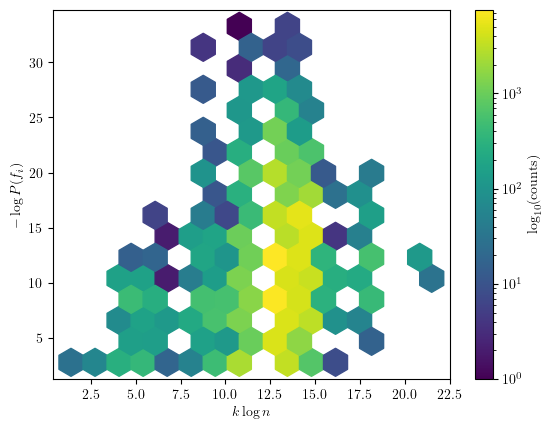

In [38]:
dirname = '../../ESR/esr/function_library/core_maths/'

fig, ax = plt.subplots()

all_klogn = []
all_logprior = []

for c in range(3, 9):
    
    klogn = np.loadtxt(dirname + f'compl_{c}/aifeyn_{c}.txt')
    logpar = np.loadtxt(dirname + f'compl_{c}/logconst_{c}.txt')
    logprior = np.loadtxt(dirname + f'compl_{c}/katz_codelen_2_{c}.txt')
    
    klogn -= logpar
    logprior -= logpar
    
    all_klogn.append(klogn)
    all_logprior.append(logprior)

hb = ax.hexbin(klogn, logprior, gridsize=15, mincnt=1, bins='log')
cb = fig.colorbar(hb, ax=ax)
cb.set_label(r'$\log_{10}({\rm counts})$')

ax.set_xlabel(r'$k \log n$')
ax.set_ylabel(r'$-\log P (f_i)$')